In [1]:
import numpy as np
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

from numba import jit

In [2]:
file_dir = "_fuzzy"
f = open('LJ_data'+file_dir+'/MC_parameter.dat', 'r')
temp = f.read().split("\t")
L=float(temp[0])
dx=float(temp[1])
N=int(L/dx)
batch_size = int(temp[2])
f.close()

In [3]:
f = open('./ML_data/parameter_kernel_sq_cubic.txt', 'r')
temp = f.read().splitlines()
dx=float(temp[0])
Lw=int(temp[1])
LLw = int((Lw-1)/2)
Nw=int(temp[2])
f.close()

In [4]:
print(str(dx)+"\t"+str(Lw)+"\t"+str(LLw)+"\t"+str(Nw))

0.03125	257	128	8


In [5]:
w1=np.loadtxt("./ML_data/w1_kernel_sq_cubic.txt")
w2=np.loadtxt("./ML_data/w2_kernel_sq_cubic.txt")

beta1 = np.zeros((Nw,Nw))
beta2 = np.zeros((Nw,Nw,Nw))
beta1=np.loadtxt("./ML_data/beta1_kernel_sq_cubic.txt")
for i in range (Nw):   
    beta2[i]=np.loadtxt("./ML_data/beta2_kernel_sq_cubic_"+str(i)+".txt")
error = np.loadtxt("./ML_data/epco_error_sq_cubic.txt")

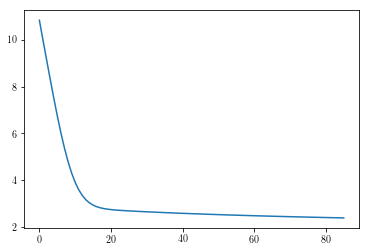

In [6]:
plt.plot(error)

(array([-0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8]),
 <a list of 8 Text yticklabel objects>)

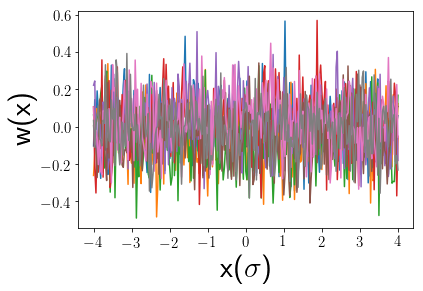

In [7]:
x = np.linspace(-LLw,LLw,Lw)*dx
for j in range (Nw):
    plt.plot(x,w1[j],label="w"+str(j))
#plt.title("w")
plt.ylabel("w(x)",size=30)
plt.xlabel("x($\sigma$)",size=30)
#plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.savefig("ML_figure/w_tri_small.png", bbox_inches='tight')
#plt.legend() 

(array([-0.6, -0.4, -0.2,  0. ,  0.2,  0.4]),
 <a list of 6 Text yticklabel objects>)

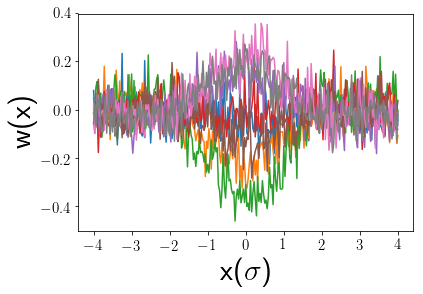

In [8]:
x = np.linspace(-LLw,LLw,Lw)*dx
for j in range (Nw):
    plt.plot(x,w2[j],label="w"+str(j))
#plt.title("w")
plt.ylabel("w(x)",size=30)
plt.xlabel("x($\sigma$)",size=30)
#plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.savefig("ML_figure/w_tri_small.png", bbox_inches='tight')
#plt.legend() 

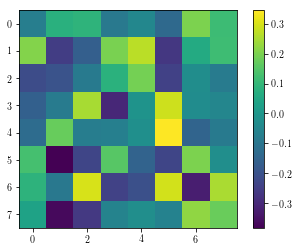

In [9]:
plt.imshow(beta1)
plt.colorbar()

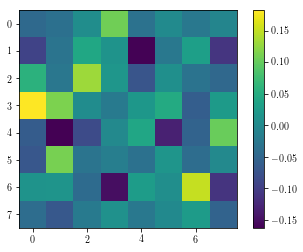

In [10]:
plt.imshow(beta2[1])
plt.colorbar()

In [11]:
def conv (rho,w):
    rho_pad=np.copy(rho)
    rho_pad=np.pad(rho_pad,(LLw,LLw),'symmetric')
    #for i in range(LLw):
    #    rho_pad[i]=rho_pad[N+i]
    #    rho_pad[N+LLw+i]=rho_pad[LLw+i]
    rho_pad[0:LLw]=rho_pad[N:N+LLw]
    rho_pad[N+LLw:N+LLw*2]=rho_pad[LLw:LLw+LLw]
    n = np.correlate(rho_pad,w)
    return n*dx

In [12]:
@jit
def cal_Utail_shift (Dx,epsilon):
    Dx = np.abs(Dx)
    Dx2=Dx**2
    if(Dx<1.):
        return 10000000
    return 4*epsilon*(1/Dx2**6-1/Dx2**3) + epsilon

def w_FMT(eps=0):
    R = 1.0/2
    k=np.linspace(0,int(N/2),int(N/2)+1)*2*np.pi/L
    w0=2*np.cos(k*R)/2
    k[0]=1 #keep notebook shutup
    w1=2*np.sin(k*R)/k
    w1[0]=2*R
    return w0,w1;

@jit
def cal_n0(rho,w0):
    return np.fft.irfft(np.fft.rfft(rho)*w0)

@jit
def cal_n1(rho,w1):
    return np.fft.irfft(np.fft.rfft(rho)*w1)

def cal_c1_FMT(rho,eps=0):
    w0,w1 = w_FMT(0)
    n0=cal_n0(rho,w0)
    n1=cal_n1(rho,w1)
    F0=-np.log(1-n1)
    F1=n0/(1-n1)
    return cal_n0(F0,w0)+cal_n1(F1,w1)

In [13]:
"""add FMT terms"""
@jit
def cal_c1(epsilon,beta1,beta2,n,nnw,w1,w2,rho):
    c1 = np.zeros(N)
       
    for i in range(Nw):
        for j in range(Nw):
            c1+=epsilon*beta1[i][j]*(conv(n[i],w1[j])+conv(n[j],w1[i]))
            
    for i in range(Nw):
        for j in range(Nw):
            for k in range(Nw):
                c1+=(epsilon*beta2[i][j][k])*(
                    nnw[i][j][k]+nnw[i][k][j]+nnw[j][k][i])
    c1+=cal_c1_FMT(rho)
    return c1

In [14]:

@jit
def cal_mu_ML(epsilon,beta1,beta2,rho0,w1,w2):
    c1=0  
    for i in range(Nw):
        for j in range(Nw):
            ni = np.sum(rho0*w1[i])
            nj = np.sum(rho0*w1[j])
            c1+=(epsilon*beta1[i][j])*(
                np.sum(ni*w1[j])+
                np.sum(nj*w1[i]))*dx*dx
    for i in range(Nw):
        for j in range(Nw):
            for k in range(Nw):
                ni = np.sum(rho0*w2[i])
                nj = np.sum(rho0*w2[j])
                nk = np.sum(rho0*w2[k])
                c1+=(epsilon*beta2[i][j][k])*(np.sum(ni*nj*w2[k])+
                                              np.sum(nj*nk*w2[i])+
                                              np.sum(nk*ni*w2[j]))*dx*dx*dx
    c1_FMT = rho0/(1-rho0)-np.log(1-rho0)
    return c1+np.log(rho0)+c1_FMT

In [15]:
def cal_f_ML(epsilon,beta1,beta2,rho0,w1,w2):
    f=0  
    for i in range(Nw):
        for j in range(Nw):
            ni = np.sum(rho0*w1[i])
            nj = np.sum(rho0*w1[j])
            f+=(epsilon*beta1[i][j])*ni*nj*dx*dx
            
    for i in range(Nw):
        for j in range(Nw):
            for k in range(Nw):
                ni = np.sum(rho0*w2[i])
                nj = np.sum(rho0*w2[j])
                nk = np.sum(rho0*w2[k])
                f+=(epsilon*beta2[i][j][k])*ni*nj*nk*dx*dx*dx
    return f

In [16]:
def pressure_ML(eps,beta1,beta2,rho0,w1,w2):
    mu=cal_mu_ML(eps,beta1,beta2,rho0,w1,w2)
    fhr = -rho0*(np.log(1-rho0))
    fML = cal_f_ML(eps,beta1,beta2,rho0,w1,w2)
    fid = rho0*(np.log(rho0)-1)
    omega = fid+fhr+fML -mu*rho0
    return -omega
    
def pressure_mean(eps,rho0):
    return rho0/(1-rho0)-75./55*2**(1.0/6)*eps*rho0**2

Text(0, 0.5, '$P$')

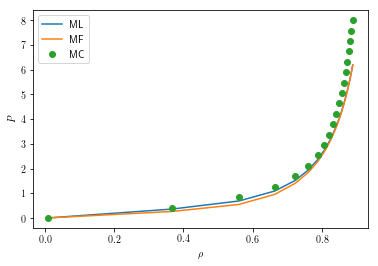

In [17]:
eps=1.5
P_MC = np.loadtxt("LJ_python_prototype/P_rho_eps_"+str(eps)+".dat")
rho0_array = np.copy(P_MC[1][np.where(P_MC[0]>0)])

P_ML = np.zeros(len(rho0_array))
P_mean = np.zeros(len(rho0_array))

for i in range (len(rho0_array)):
    P_ML[i]=pressure_ML(eps,beta1,beta2,rho0_array[i],w1,w2)
    P_mean[i]=pressure_mean(eps,rho0_array[i])
    
plt.plot(rho0_array,P_ML,label="ML")
plt.plot(rho0_array,P_mean,label="MF")
plt.plot(P_MC[1][np.where(P_MC[1]>0)],P_MC[0][np.where(P_MC[1]>0)],'o',label="MC")
plt.legend()
plt.xlabel(r"$\rho$")
plt.ylabel(r"$P$")

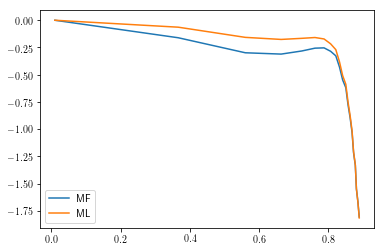

In [18]:
 
plt.plot(rho0_array,P_mean-P_MC[0],label="MF")
plt.plot(rho0_array,P_ML-P_MC[0],label="ML")
plt.legend()

(0, 0.4)

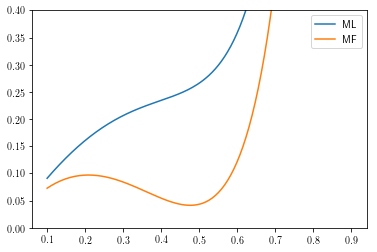

In [19]:
eps=2.5
rho0_array = np.linspace(0.1,0.9,200)
P_ML = np.zeros(len(rho0_array))
P_mean = np.zeros(len(rho0_array))

for i in range (len(rho0_array)):
    P_ML[i]=pressure_ML(eps,beta1,beta2,rho0_array[i],w1,w2)
    P_mean[i]=pressure_mean(eps,rho0_array[i])

plt.plot(rho0_array,P_ML,label="ML")
plt.plot(rho0_array,P_mean,label="MF")
plt.legend()
plt.ylim([0,0.4])

In [20]:
gold=1.618

In [21]:
@jit
def cal_rho_ML(mu,c1,V):
    rho_ML = np.exp(-c1-V+mu)
    return rho_ML

In [22]:
@jit
def cal_n (rho,w):
    n_array = np.zeros((Nw,N))
    for j in range (Nw):
        n_array[j] = conv(rho,w[j])
    return n_array

@jit
def cal_nnw (nnw,rho,w):
    n_array = np.zeros((Nw,N))
    for j in range (Nw):
        n_array[j] = conv(rho,w[j])
    for i in range (Nw):
        for j in range (Nw):
            for k in range (Nw):
                nnw[i][j][k] = conv(n_array[i]*n_array[j],w[k])
    return nnw

@jit
def picard_update(rho,mu,alpha,epsilon,Vext):
    n_array = np.zeros((Nw,N))
    n_array = cal_n(rho,w1)
    
    nnw = np.zeros((Nw,Nw,Nw,N))
    nnw=cal_nnw(nnw,rho,w2)
    
    
    c1 = cal_c1(epsilon,beta1,beta2,n_array,nnw,w1,w2,rho)
    mu_ML = mu
    #mu=np.log(np.sum(np.sum(rho)/np.sum(np.exp(-c1[int(1.0/dx):N]))))
    rho_new = cal_rho_ML(mu_ML,c1,Vext)
    error = np.sum((rho_new-rho)**2)
    rho=(1-alpha)*rho+alpha*rho_new
    return rho,error


In [23]:
rho_ML=np.zeros(N)
rho_MC=np.zeros(N)
Vext=np.zeros(N)


rho_ML=np.full(N,0.5)
eps = 2
z=1.5
mu = np.log(z)
alpha = 10**-2
thread = 10**-6
error=0
Vext = np.zeros(N)
Vext[0:int(1/dx)]=10**8

for iteration in range(1000000):

    rho_ML,error=picard_update(rho_ML,mu,alpha,eps,Vext)
    
    if(error<thread):
        print(iteration," error=",error)
        break    

    if(iteration%100==0):
        print(iteration," error=",error, "alpha=", alpha)
    if(np.isnan(error)):
        break

0  error= 3170.1221348374993 alpha= 0.01
100  error= 3.9251773213660957 alpha= 0.01
200  error= 1.047368370518801 alpha= 0.01
300  error= 0.34355680017444556 alpha= 0.01
400  error= 0.12829968302577305 alpha= 0.01
500  error= 0.05206583001285847 alpha= 0.01
600  error= 0.022341422480535413 alpha= 0.01
700  error= 0.009969142875183391 alpha= 0.01
800  error= 0.004575905411697613 alpha= 0.01
900  error= 0.002144730765169331 alpha= 0.01
1000  error= 0.001021242029522871 alpha= 0.01
1100  error= 0.0004922382033889948 alpha= 0.01
1200  error= 0.0002395389753283183 alpha= 0.01
1300  error= 0.00011745966462250898 alpha= 0.01
1400  error= 5.7952765112417585e-05 alpha= 0.01
1500  error= 2.8736785048832105e-05 alpha= 0.01
1600  error= 1.4308433658421231e-05 alpha= 0.01
1700  error= 7.148686179930266e-06 alpha= 0.01
1800  error= 3.5817194065984697e-06 alpha= 0.01
1900  error= 1.7988150044011254e-06 alpha= 0.01
1986  error= 9.964461912430259e-07


In [24]:
@jit
def cal_Utail (Dx,epsilon):
    Dx = np.abs(Dx)
    if Dx>L/2:
        Dx= np.abs(Dx)-L
        
    if np.abs(Dx)<=2**(1.0/6):
        return -epsilon
    #if np.abs(Dx)<=1:
    #    return 0
    
    
    else:
        Dx2=Dx**2
        return 4*epsilon*(1/Dx2**6-1/Dx2**3)

In [25]:
@jit
def cal_Utail (Dx,epsilon):
    Dx = np.abs(Dx)
    if Dx>L/2:
        Dx= np.abs(Dx)-L
        
    if np.abs(Dx)<=1:
        return -epsilon
    
    else:
        Dx2=Dx**2
        return 4*epsilon*(1/Dx2**6-1/Dx2**3)

@jit
def cal_Ftail_drho(rho,epsilon):
    Utail = np.zeros(N)
    for i in range (N):
        Utail[i]=cal_Utail(i*dx,epsilon)        
    Ftail = np.zeros(N)
    
    for i in range (N):
        for j in range (N):
            Ftail[i]+=Utail[np.abs(i-j)]*rho[j]*dx
    return Ftail

@jit
def cal_c1_mean(rho,epsilon):
    Ftail=cal_Ftail_drho(rho,epsilon)
    return cal_c1_FMT(rho,epsilon)+Ftail

@jit
def update_rho_mean(rho,alpha,eps,mu,Vext):
    c1 = cal_c1_mean(rho,eps)
    #mu=np.log(np.sum(np.sum(rho)/np.sum(np.exp(-c1-Vext))))
    rho_new =np.exp(mu-c1-Vext)
    rho = (1-alpha)*rho+alpha*rho_new
    err = np.sum((rho_new-rho)**2)
    return rho,err




In [26]:
rho_mean = np.full(N,0.1)
alpha = 0.01
Vext = np.zeros(N)
Vext[0:int(1/dx)]=10**8
for i in range (100000):
    rho_mean,err=update_rho_mean(rho_mean,alpha,eps,mu,Vext)
    if(i%10000==0):
        print(i,err)
    if(err<10**-6):
        print(i,err)
        break;

0 4116.71226795361
8015 9.995097789149248e-07


(0, 16.0)

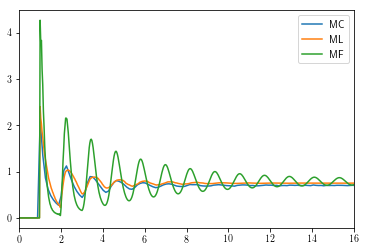

In [27]:
rho_MC = np.loadtxt("LJ_python_prototype/wall_mu_ln_"+str(z)+"_eps_"+str(eps)+"_MC.dat")
x_MC = np.linspace(0,L,len(rho_MC))
plt.plot(x_MC,rho_MC,label="MC")

x_sys = np.linspace(0,L,N)
plt.plot(x_sys,rho_ML,label="ML")
plt.plot(x_sys,rho_mean,label="MF")
plt.legend()
plt.xlim([0,L/2])